In [36]:
import yfinance as yf
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import scipy.stats as stats
from outliers import smirnov_grubbs as grubbs
from pyod.models.hbos import HBOS
from sklearn.svm import OneClassSVM
from scipy.stats import shapiro
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import requests
import time

We have taken 'India Bulls Housing Finance' as our company of interest from period 1st January,2020 to 20th May,2021. 

In [6]:
df = yf.download("IBULHSGFIN.NS", start="2020-01-01", end="2021-05-20",group_by="ticker") 

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.to_csv('India_Bulls_Housing_Finance.csv')

Main code start from this cell

In [ ]:
df=pd.read_csv('India_Bulls_Housing_Finance.csv')

We started with features -
  1. Close - Closing Price of share.
  2. Volume - Number of shares traded in a day.
  3. Fluctuations - Difference of daily high and daily low
  4. Lag 1 - Momentum of 1 day ( Today's closing price - yesterday's closing price)
  5. Lag 2 - Momentum of 2 days
  6. Lag 3 - Momentum of 3 days
  7. Lag 4 - Momentum of 4 days
  8. Lag 5 - Momentum of 5 days  #Maximum momentum for a week to be considered for anomaly 
  9. Log daily Returns - It is log(today's closing price) - log(yesterday's closing price). Mean of the variable gives     central tendency. Positive value indicates stock is growing on average. It's standard deviation gives the volatility  (Higher the value of standard deviation more the risk).
  
Methods used (explained further in notebook)- 
1. Bollinger Bands
2. CCI 
3. Isolation Forest
4. DBSCAN
5. HBOS
6. Local Outlier Factor
7. GESD test

so df11 means outlier from close as feature and algorithm as bollinger bands

df1233 means outlier from close, volume and fluctuations with isolation forest as algorithm 

do1 = Final output anomaly from bollinger bands and CCI index
do2 = Final output anomaly from HBOS

In [7]:
df['Fluctuations'] = df['High'] - df['Low']
df['Daily Log Returns']=np.log(df['Close'])-np.log(df['Close'].shift(1))
df['Lag1']=(df['Close']-df['Close'].shift(1))
df['Lag2']=(df['Close']-df['Close'].shift(2))
df['Lag3']=(df['Close']-df['Close'].shift(3))
df['Lag4']=(df['Close']-df['Close'].shift(4))
df['Lag5']=(df['Close']-df['Close'].shift(5))
df.drop('Adj Close',axis=1,inplace=True)
df.drop('Open',axis=1,inplace=True)
df.reset_index(inplace=True)
df.tail()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5
337,2021-05-12,192.949997,184.500000,187.699997,14808531,8.449997,0.015030,2.800003,0.899994,7.899994,11.099991,8.149994
338,2021-05-14,190.550003,182.100006,183.800003,12309820,8.449997,-0.020997,-3.899994,-1.099991,-3.000000,4.000000,7.199997
339,2021-05-17,188.649994,184.350006,187.699997,8300469,4.299988,0.020997,3.899994,0.000000,2.800003,0.899994,7.899994
340,2021-05-18,194.699997,189.000000,191.850006,11282907,5.699997,0.021869,4.150009,8.050003,4.150009,6.950012,5.050003
341,2021-05-19,194.800003,190.550003,193.250000,9321102,4.250000,0.007271,1.399994,5.550003,9.449997,5.550003,8.350006


In [4]:
df.shape[0]

342

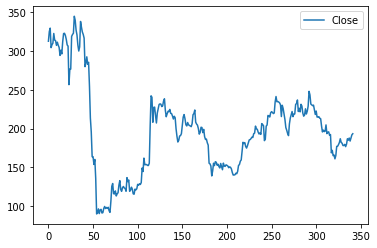

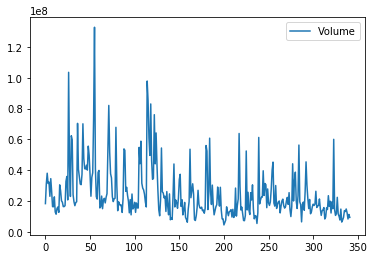

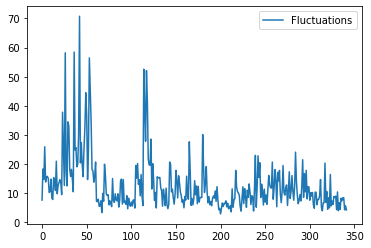

In [6]:
df.plot(y="Close")
df.plot(y="Volume")
df.plot(y="Fluctuations")

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


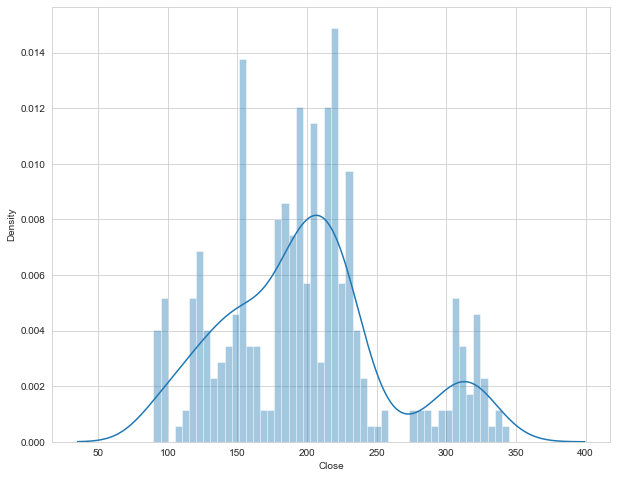

In [7]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Close'], bins=50, kde=True);

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


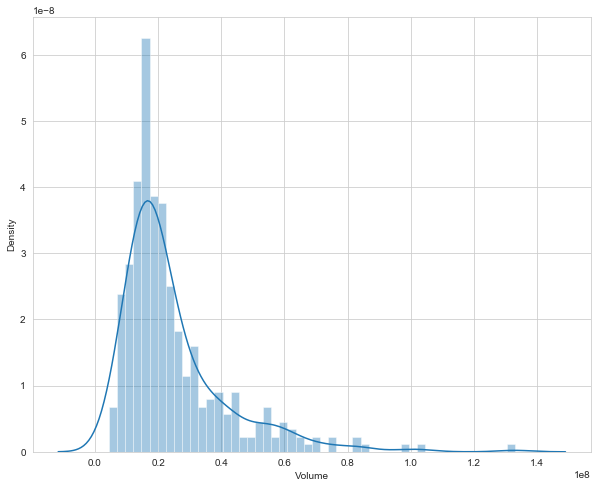

In [8]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Volume'], bins=50, kde=True);

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


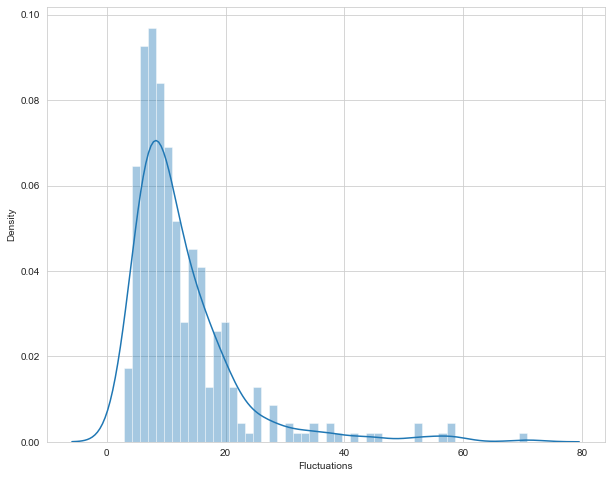

In [9]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Fluctuations'], bins=50, kde=True);

In [10]:
print(df['Daily Log Returns'].std()) # High volatile share

0.05321507954622793


Creating more features such as :
   1. 21 days moving average
   2. 7 days moving average
   3. 21 days exponential moving average - weighted average ( more weight to recent price)
   
 Then creating bollinger bands ( bands 2 standard deviation away from 21 days moving average ). Anything away from it is an outlier. This is done for Closing Price, Volume and Fluctuations. 
 

In [8]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Close'] = dataset['Close'].rolling(window=21).mean()
    dataset['ma7_Close'] = dataset['Close'].rolling(window=7).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Close'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Close'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Close'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Close'] = dataset['Close'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,upper_band,lower_band,ema21_Close
0,2020-01-01,318.299988,310.649994,312.700012,18294197,7.649994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.700012
1,2020-01-02,328.600006,310.299988,325.149994,31124957,18.300018,0.039042,12.449982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.221431
2,2020-01-03,335.799988,321.049988,329.600006,38042432,14.750000,0.013593,4.450012,16.899994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323.015412
3,2020-01-06,327.149994,301.200012,304.399994,31387511,25.949982,-0.079537,-25.200012,-20.750000,-8.300018,NaN,NaN,NaN,NaN,NaN,NaN,317.676666
4,2020-01-07,317.399994,303.549988,308.200012,32305742,13.850006,0.012406,3.800018,-21.399994,-16.949982,-4.5,NaN,NaN,NaN,NaN,NaN,315.404013


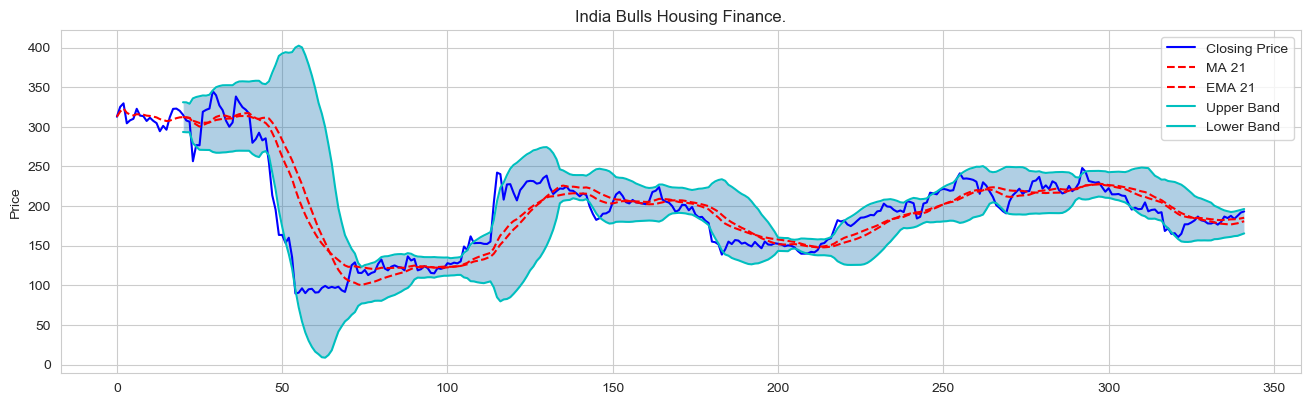

In [12]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21_Close'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Close'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Price')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

Boxplot of 7 days moving average of closing price and month. I have split dataframe into 2 in terms of year.

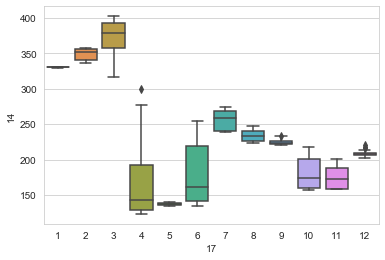

In [13]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[17],y=df1[14])        # 17th column is month and 14th column is 7 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

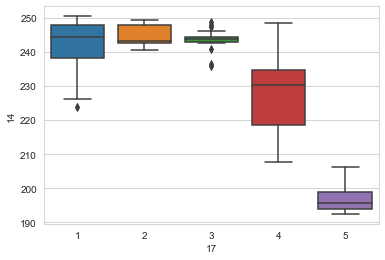

In [14]:
sns.boxplot(x=df2[17],y=df2[14])

Storing anomalies from bollinger bands for closing price in another dataframe then analyzing

In [9]:
df11=pd.DataFrame()
df11=pd.DataFrame(df[(df['Close']>df['upper_band']) | (df['Close']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df11.shape[0]

40

Doing the same thing for volume but not adding 7 days moving average of volume.

In [10]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Volume'] = dataset['Volume'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Volume'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Volume'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Volume'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Volume'] = dataset['Volume'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,upper_band,lower_band,ema21_Volume
0,2020-01-01,318.299988,310.649994,312.700012,18294197,7.649994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.700012,NaN,NaN,NaN,1.829420e+07
1,2020-01-02,328.600006,310.299988,325.149994,31124957,18.300018,0.039042,12.449982,NaN,NaN,NaN,NaN,NaN,NaN,319.221431,NaN,NaN,NaN,2.501507e+07
2,2020-01-03,335.799988,321.049988,329.600006,38042432,14.750000,0.013593,4.450012,16.899994,NaN,NaN,NaN,NaN,NaN,323.015412,NaN,NaN,NaN,2.977734e+07
3,2020-01-06,327.149994,301.200012,304.399994,31387511,25.949982,-0.079537,-25.200012,-20.750000,-8.300018,NaN,NaN,NaN,NaN,317.676666,NaN,NaN,NaN,3.023912e+07
4,2020-01-07,317.399994,303.549988,308.200012,32305742,13.850006,0.012406,3.800018,-21.399994,-16.949982,-4.5,NaN,NaN,NaN,315.404013,NaN,NaN,NaN,3.073473e+07


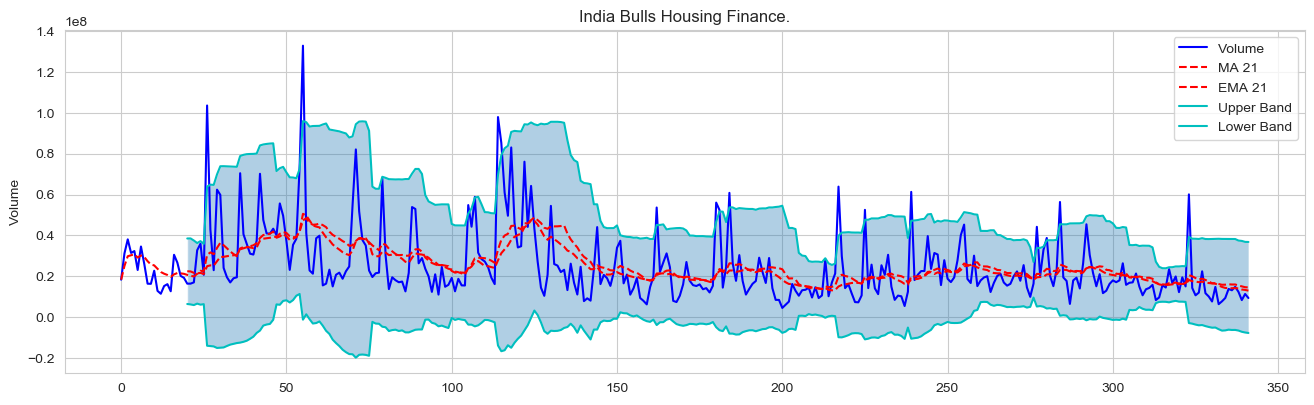

In [17]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Volume'],label='Volume', color='b')
    plt.plot(dataset['ma21_Volume'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Volume'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Volume')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

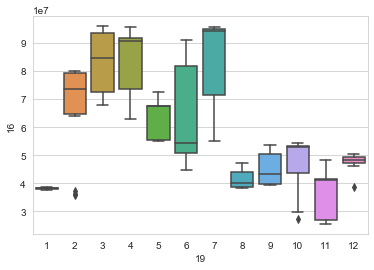

In [18]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[19],y=df1[16])        # 19th column is month and 16th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

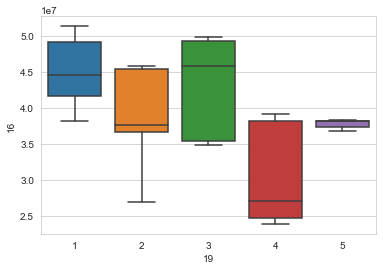

In [19]:
sns.boxplot(x=df2[19],y=df2[16])

In [11]:
df21=pd.DataFrame()
df21=pd.DataFrame(df[(df['Volume']>df['upper_band']) | (df['Volume']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df21.shape[0]

18

Doing same thing for fluctuations as volume

In [12]:
def get_technical_indicators(dataset):
    # Create 21 days Moving Average
    dataset['ma21_Fluctuations'] = dataset['Fluctuations'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['21sd'] = dataset['Fluctuations'].rolling(window=21).std()
    dataset['upper_band'] = dataset['ma21_Fluctuations'] + (dataset['21sd']*2)
    dataset['lower_band'] = dataset['ma21_Fluctuations'] - (dataset['21sd']*2)

    # Create MACD
    dataset['ema21_Fluctuations'] = dataset['Fluctuations'].ewm(span=21).mean()

    dataset.drop('21sd',axis=1,inplace=True)

    return dataset

df = get_technical_indicators(df)
df.head()

,Date,High,Low,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,...,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,upper_band,lower_band,ema21_Fluctuations
0,2020-01-01,318.299988,310.649994,312.700012,18294197,7.649994,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,312.700012,NaN,1.829420e+07,NaN,NaN,NaN,7.649994
1,2020-01-02,328.600006,310.299988,325.149994,31124957,18.300018,0.039042,12.449982,NaN,NaN,...,NaN,NaN,NaN,319.221431,NaN,2.501507e+07,NaN,NaN,NaN,13.228578
2,2020-01-03,335.799988,321.049988,329.600006,38042432,14.750000,0.013593,4.450012,16.899994,NaN,...,NaN,NaN,NaN,323.015412,NaN,2.977734e+07,NaN,NaN,NaN,13.784747
3,2020-01-06,327.149994,301.200012,304.399994,31387511,25.949982,-0.079537,-25.200012,-20.750000,-8.300018,...,NaN,NaN,NaN,317.676666,NaN,3.023912e+07,NaN,NaN,NaN,17.273635
4,2020-01-07,317.399994,303.549988,308.200012,32305742,13.850006,0.012406,3.800018,-21.399994,-16.949982,...,NaN,NaN,NaN,315.404013,NaN,3.073473e+07,NaN,NaN,NaN,16.452594


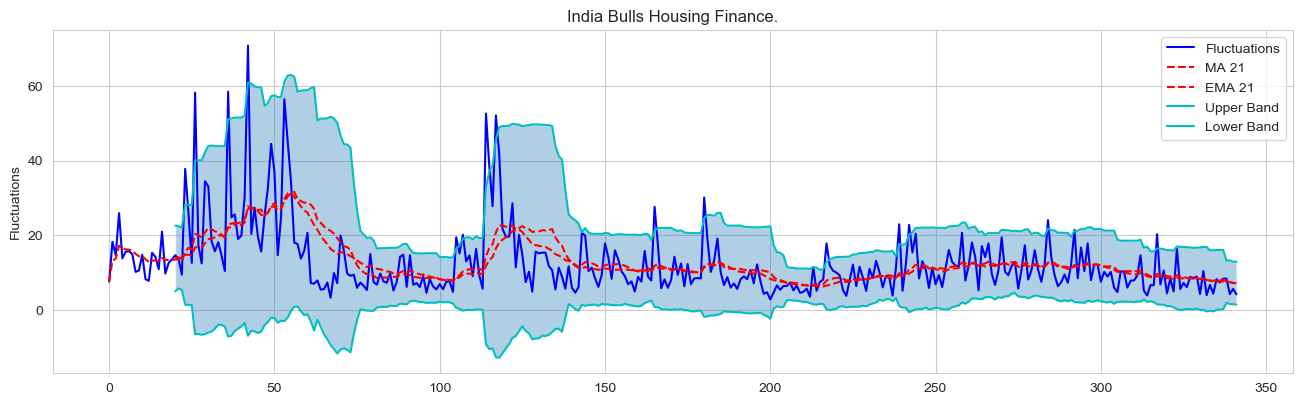

In [164]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Fluctuations'],label='Fluctuations', color='b')
    plt.plot(dataset['ma21_Fluctuations'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['ema21_Fluctuations'],label='EMA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('India Bulls Housing Finance.')
    plt.ylabel('Fluctuations')
    plt.legend()  
   
    plt.show()
    
plot_technical_indicators(df, 365)

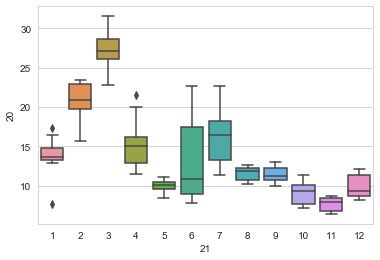

In [22]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1=pd.DataFrame(df[df['Year']== 2020].values.tolist()) 
df2=pd.DataFrame(df[df['Year']== 2021].values.tolist())
sns.boxplot(x=df1[21],y=df1[20])        # 17th column is month and 15th column is 21 days moving average
df1.head()
df.drop('Month', axis=1, inplace=True)
df.drop('Year', axis=1, inplace=True)

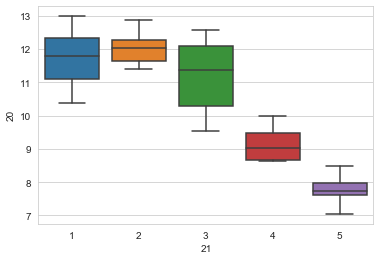

In [23]:
sns.boxplot(x=df2[21],y=df2[20])

In [13]:
df31=pd.DataFrame()
df31=pd.DataFrame(df[(df['Fluctuations']>df['upper_band']) | (df['Fluctuations']<df['lower_band'])].values.tolist())
df.drop('upper_band',axis=1,inplace=True)
df.drop('lower_band',axis=1,inplace=True)
df31.shape[0]

17

The Commodity Channel Index (CCI) is a technical indicator that measures the difference between the current price and the historical average price. When the CCI is above zero, it indicates the price is above the historic average. Conversely, when the CCI is below zero, the price is below the historic average.

CCI = (Typical Price - 20 days MA of TP) / (. 015 x Mean Deviation) 

Typical Price (TP) = (High + Low + Close)/3 

Mean Deviation = [Σ |X – µ|]/N

It is somewhat similat to bollinger bands.

In [14]:
#momentum based oscillator to determine the price current trend w.r.t to previous trends
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 
df['sma'] = df['TP'].rolling(21).mean()
df['mad'] = df['TP'].rolling(21).apply(lambda x: pd.Series(x).mad())
df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
df.drop('High',axis=1,inplace=True)
df.drop('Low',axis=1,inplace=True)
df.drop('TP',axis=1,inplace=True)
df.drop('sma',axis=1,inplace=True)
df.drop('mad',axis=1,inplace=True)
df.head()

,Date,Close,Volume,Fluctuations,Daily Log Returns,Lag1,Lag2,Lag3,Lag4,Lag5,ma21_Close,ma7_Close,ema21_Close,ma21_Volume,ema21_Volume,ma21_Fluctuations,ema21_Fluctuations,CCI
0,2020-01-01,312.700012,18294197,7.649994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,312.700012,NaN,1.829420e+07,NaN,7.649994,NaN
1,2020-01-02,325.149994,31124957,18.300018,0.039042,12.449982,NaN,NaN,NaN,NaN,NaN,NaN,319.221431,NaN,2.501507e+07,NaN,13.228578,NaN
2,2020-01-03,329.600006,38042432,14.750000,0.013593,4.450012,16.899994,NaN,NaN,NaN,NaN,NaN,323.015412,NaN,2.977734e+07,NaN,13.784747,NaN
3,2020-01-06,304.399994,31387511,25.949982,-0.079537,-25.200012,-20.750000,-8.300018,NaN,NaN,NaN,NaN,317.676666,NaN,3.023912e+07,NaN,17.273635,NaN
4,2020-01-07,308.200012,32305742,13.850006,0.012406,3.800018,-21.399994,-16.949982,-4.5,NaN,NaN,NaN,315.404013,NaN,3.073473e+07,NaN,16.452594,NaN


We have taken the assumption that nearly 10% of the values in the dataset are outliers for fine tuning the model.

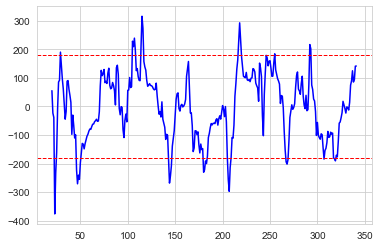

In [26]:
plt.plot(df['CCI'], color = 'blue')
plt.axhline(180, linestyle = '--', linewidth = 1, color = 'red')
plt.axhline(-180, linestyle = '--', linewidth = 1, color = 'red')
plt.show()

In [15]:
df12=pd.DataFrame()
df12=pd.DataFrame(df[(df['CCI']>180) | (df['CCI']<-180)].values.tolist())
df12.shape[0]

39

35 out of 39 anomalies of CCI index same as Bollinger bands 

In [16]:
print(pd.merge(df11, df12, on=0).shape[0]) 
df12.set_index(0,inplace=True)
df11_12 = pd.concat([df11,df12]).reset_index()
df11_12=df11_12.drop_duplicates(subset=0)
df11_12.shape[0]

35


41

Most coomon anomaly

Share Bashing - False and/or misleading information about the target company in an attempt to get shares for a cheaper price. This activity, in most cases, is conducted by posting libelous posts on multiple public forums. The perpetrators sometimes work directly for unscrupulous Investor Relations firms who have convertible notes that convert for more shares the lower the bid or ask price is; thus the lower these Bashers can drive a stock price down by trying to convince shareholders they have bought a worthless security, the more shares the Investor Relations firm receives as compensation. Immediately after the stock conversion is complete and shares are issued to the Investor Relations firm, consultant, attorney or similar party, the basher/s then become friends of the company and move quickly to ensure they profit on a classic Pump & Dump scheme to liquidate their ill-gotten shares. 


Means either the stock price will shoot up and volume of share shoots up then it indicates an anomaly else stock price drops suddenly and volume of share traded increases cause an anomaly. 

The closing price only not accounts for anomaly. 

So we will take all anomalies of closing price from bollinger bands and CCI index and volume anomaly from bollinger bands and take intersection of both, it will give us anomaly. 

Also it might happen that this anomaly persists for a day only and the share price closes normally. So we will take intersection of anomaly of volume and fluctuations as well.

In [17]:
df12.reset_index(0,inplace=True)
df21.reset_index(0,inplace=True)
df31.reset_index(0,inplace=True)

dmerge1 = pd.merge(df11_12, df21, on=0)
dmerge2 = pd.merge(df31, df21, on=0)
dmerge1.set_index(0,inplace=True)
dmerge2.set_index(0,inplace=True)
do1 = pd.concat([dmerge1,dmerge2]).reset_index()
do1 = do1.drop_duplicates(subset=0)
print(do1.shape[0])
do1.head()

11


,0,index_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,13_y,14_y,15_y,16_y,17_y,18,18_x,19,20,18_y
0,2020-03-19,7,126.650002,81.400002,89.750000,73985571.0,45.250000,-0.411575,-45.699997,-70.350006,...,151.664289,220.911105,4.192224e+07,7.256467e+07,1.127981e+07,4.227611e+07,NaN,NaN,NaN,NaN
1,2020-06-08,8,152.300003,132.800003,149.000000,54828918.0,19.500000,0.134491,18.750000,21.250000,...,130.364285,126.771332,2.346528e+07,5.064099e+07,-3.710427e+06,2.391796e+07,NaN,NaN,NaN,NaN
2,2020-06-10,10,164.699997,144.500000,161.800003,58870168.0,20.199997,0.113082,17.300003,12.800003,...,138.392857,131.421093,2.694897e+07,5.846688e+07,-4.568933e+06,2.877475e+07,NaN,NaN,NaN,NaN
3,2020-06-19,11,209.449997,156.850006,203.399994,97948282.0,52.599991,0.270782,48.250000,51.149994,...,160.471427,146.652343,2.779309e+07,6.952302e+07,-1.393684e+07,3.303069e+07,NaN,NaN,NaN,NaN
4,2020-06-22,12,254.250000,215.800003,242.199997,85313320.0,38.449997,0.174589,38.800003,87.050003,...,173.185713,155.338630,3.126917e+07,7.927379e+07,-1.673545e+07,3.778373e+07,NaN,NaN,NaN,NaN


Now we will use isolation forest.

Isolation forest randomly forms multiple decision trees to form a forest and gives score according to -
 
      s(x) = 2 pow (-E(h(x))/c(n))
      
E(h(x)) = average path length of all trees

c(n) = 2*H(n-1) - 2*(n-1)/n            (can be easily proved by graphs data structure)

It gives us mostly global anomalies. We are using 3 features Close, Volume, Fluctuations.

It mostly gives global features but sometimes gives local anomalies as well. We have taken lag of 5 days so only using global outlier function foe lag such as HBOS.

In [18]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=x.shape[1], bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x)
pred = clf.predict(x)
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
df1233=pd.DataFrame()
df1233=pd.DataFrame(outliers.values.tolist())
df.drop('anomaly',axis=1,inplace=True)
df1233.shape

C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

(35, 19)

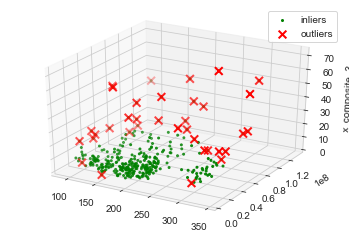

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1233[1],df1233[2], df1233[3],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

It can be easily visualized above that all outliers are are global outliers and we can also set the threshold by observing.

We can observe below a high Correlation between volume and fluctuations

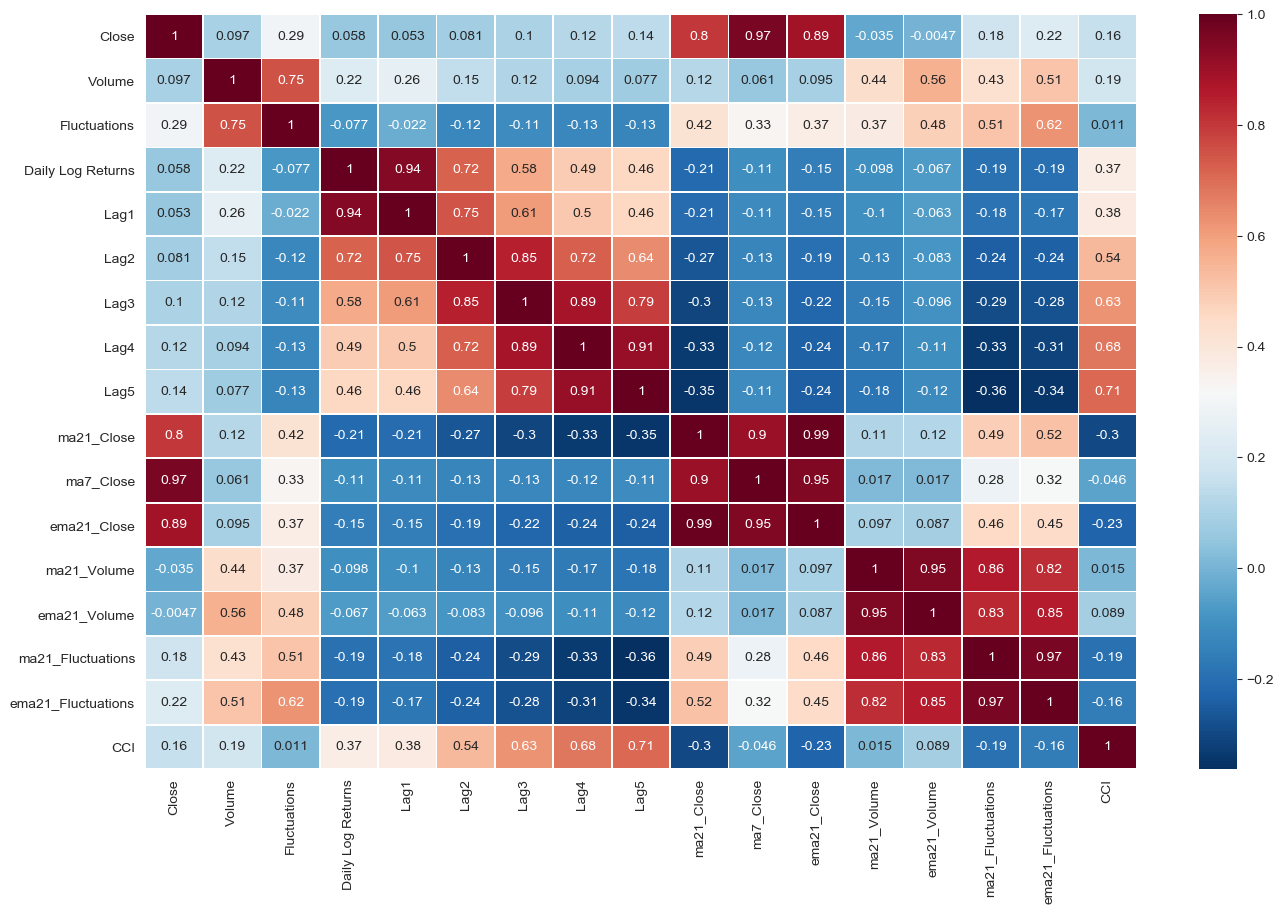

In [34]:
corr = df.corr()
plt.figure(figsize=(16, 10), dpi=100)
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu_r',annot=True,linewidth=0.5)

GESD (Generalized Extreme Studentized Deviate) -  The GESD test only requires that an upper bound for the suspected number of outliers be specified.
Given the upper bound, r, the generalized ESD test essentially performs r separate tests: a test for one outlier, a test for two outliers, and so on up to r outliers.

The generalized ESD test is defined for the hypothesis:

H0: There are no outliers in the data set

Ha: There are up to r outliers in the data set

Our test statistic is given by the formula below:

            R = max|xi - x_bar| / standard deviation

In GESD we remove the observation that maximizes |xi — x_bar| and then recompute the above statistic with n-1 observations. We repeat this process until r observations have been removed. This results in the r statistics R1, R2 ………., Rr. 

Corresponding to the r test statistics, compute the following r critical values:

               λi= ((n−i) * t (p,n−i−1)) / root ((n−i−1+t(p,n−i−1)*t(p,n−i−1))(n−i+1))

We are performing GESD test for Lag1. But first we have to identify if the feature is normally distributed which is foremost condition of GESD test.

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


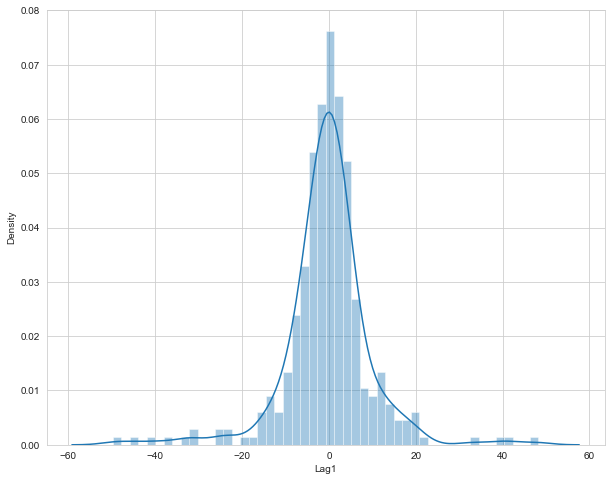

In [22]:
plt.figure(figsize=(10,8)) 
sns.set_style('whitegrid')
sns.distplot(df['Lag1'], bins=50, kde=True);

Shapiro test a p score of 1 signifying the feature is a perfect normal distribution

In [24]:
shapiro(df['Lag1'])

(nan, 1.0)

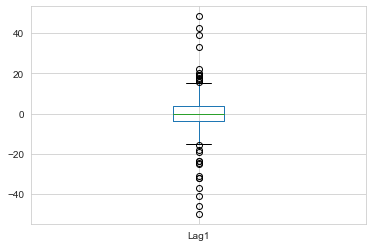

In [25]:
df['Lag1'].plot(kind='box')

In [19]:
global df47
df47 = []
def test_stat(y, iteration):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    cal = max_of_deviations/ std_dev
    print('Test {}'.format(iteration))
    print("Test Statistics Value(R{}) : {}".format(iteration,cal))
    return cal, max_ind

def calculate_critical_value(size, alpha, iteration):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Critical Value(λ{}): {}".format(iteration, critical_value))
    return critical_value

def check_values(R, C, inp, max_index, iteration):
    if R > C:
        print('{} is an outlier. R{} > λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))
        df47.append(inp[max_index])
    else:
        print('{} is not an outlier. R{}> λ{}: {:.4f} > {:.4f} \n'.format(inp[max_index],iteration, iteration, R, C))

def ESD_Test(input_series, alpha, max_outliers):
    stats = []
    critical_vals = []
    for iterations in range(1, max_outliers + 1):
        stat, max_index = test_stat(input_series, iterations)
        critical = calculate_critical_value(len(input_series), alpha, iterations)
        check_values(stat, critical, input_series, max_index, iterations)
        input_series = np.delete(input_series, max_index)
        critical_vals.append(critical)
        stats.append(stat)
        if stat > critical:
            max_i = iterations
    print('H0:  there are no outliers in the data')
    print('Ha:  there are up to 10 outliers in the data')
    print('')
    print('Significance level:  α = {}'.format(alpha))
    print('Critical region:  Reject H0 if Ri > critical value')
    print('Ri: Test statistic')
    print('λi: Critical Value')
    print(' ')

x=np.array(df['Lag1'])
ESD_Test(x, 0.05, 30)

Test 1
Test Statistics Value(R1) : nan
Critical Value(λ1): 3.7602390599327262
nan is not an outlier. R1> λ1: nan > 3.7602 

Test 2
Test Statistics Value(R2) : 4.9295639954186585
Critical Value(λ2): 3.7594263142134867
-49.79998779296875 is an outlier. R2 > λ2: 4.9296 > 3.7594 

Test 3
Test Statistics Value(R3) : 5.005494939993807
Critical Value(λ3): 3.758610862817888
48.25 is an outlier. R3 > λ3: 5.0055 > 3.7586 

Test 4
Test Statistics Value(R4) : 4.861179237575472
Critical Value(λ4): 3.7577926883926085
-45.69999694824219 is an outlier. R4 > λ4: 4.8612 > 3.7578 

Test 5
Test Statistics Value(R5) : 4.712562603484596
Critical Value(λ5): 3.7569717734200845
42.25 is an outlier. R5 > λ5: 4.7126 > 3.7570 

Test 6
Test Statistics Value(R6) : 4.644794938255044
Critical Value(λ6): 3.7561481002159676
-40.850006103515625 is an outlier. R6 > λ6: 4.6448 > 3.7561 

Test 7
Test Statistics Value(R7) : 4.617873011198618
Critical Value(λ7): 3.755321650927375
38.80000305175781 is an outlier. R7 > λ7: 4.6

In [36]:
df47 = pd.DataFrame(df47)
df47.shape

(11, 1)

In [37]:
df47.rename(columns={0:'Lag1'}, inplace=True)
df47 = pd.merge(df, df47, on='Lag1')
df47.shape

(11, 18)

Now we will use DBSCAN with features Close, Volume and Fluctuations. 

DBSCAN - It is a clustering algorithm which uses minimum samples near to core point and distance from core point to find the clusters of values and find the outliers. It is used for global outliers. 

Normal practice is to choose minimum samples to be 2*dimension and distance by how much number of outliers you want.

In [20]:
min_max_scaler = MinMaxScaler()
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
model = DBSCAN(eps = 0.15, min_samples = 6).fit(x)
print(model.labels_)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0 -1  0  0 -1 -1  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0  0  0
 -1 -1 -1  0  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0 -1 -1  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

C:\Users\karti\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [21]:
df['anomaly'] = model.labels_
df1234=pd.DataFrame()
df1234=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1234.shape[0]

18

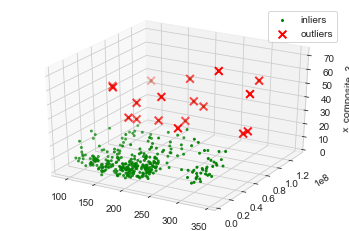

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1234['Close'],df1234['Volume'], df1234['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

Now we will use HBOS ( Histogram based outlier selection ) with features Close, Volume, Fluctuations, Lag1, Lag2, Lag3, Lag4, Lag5 because this method is proximity based (outlier when locality is sparse) method detecting only global outliers.
Also we used mode of the column to fill NaN values.

HBOS - For multivariate analysis it plots histogram for all individual features and do combined scoring based on the height of individual bins. If the score is higher than threshold value is considered as an outlier.

In [30]:
x.dtypes

Close           float64
Volume            int64
Fluctuations    float64
Lag1            float64
Lag2            float64
Lag3            float64
Lag4            float64
Lag5            float64
dtype: object

In [ ]:
x=pd.DataFrame(df[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']] = min_max_scaler.fit_transform(x[['Close','Volume','Fluctuations','Lag1', 'Lag2', 'Lag3','Lag4','Lag5']])
hbos = HBOS(n_bins=100)
x=x.fillna(x.mode().iloc[0])
hbos.fit(x)
output = hbos.decision_function(x)

In [18]:
df['anomaly'] = hbos.predict(x)
dfo2=pd.DataFrame()
dfo2=pd.DataFrame(df[df['anomaly']==1])
df.drop('anomaly', axis=1, inplace =True)
dfo2.shape[0]

35

We can observe that all the outliers from this are coming from - 

1. Close = (250 - 275)
2. Volume = greater than 0.7*e8
3. Fluctuations = greater than 30
4. Lag1 = Less than -20 and greater than 20
5. Lag2 = Less than -40 and greater than 40 
6. Lag3 = Less than -50 and greater than 50
7. Lag4 = Less than -50 and greater than 50
8. Lag5 = Less than -50 and greater than 50

These bins are responsible for high scores. We can visualize by plotting histogram of each feature. 

In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dfo2)

          Date       Close     Volume  Fluctuations  Daily Log Returns  \
17  2020-01-24  322.600006   26672842      9.799988           0.033090   
23  2020-02-03  256.600006   32693890     37.800003          -0.177373   
24  2020-02-04  276.850006   35923574     25.900024           0.075957   
26  2020-02-06  318.950012  103611027     58.199982           0.142100   
27  2020-02-07  321.399994   42832351     17.399994           0.007652   
29  2020-02-11  344.950012   62386677     34.500000           0.065747   
30  2020-02-12  339.750000   59833683     33.100006          -0.015189   
36  2020-02-20  338.200012   70436641     58.450012           0.101851   
41  2020-02-28  279.850006   37439449     30.449982          -0.123701   
42  2020-03-02  284.399994   70157790     70.750000           0.016128   
43  2020-03-03  292.549988   47549484     20.399994           0.028254   
46  2020-03-06  254.500000   43258904     15.699997          -0.114766   
47  2020-03-09  213.649994   40079520 

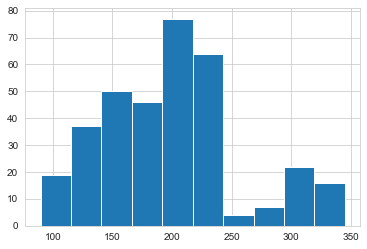

In [46]:
df['Close'].hist()

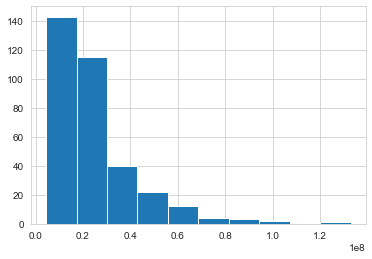

In [47]:
df['Volume'].hist()

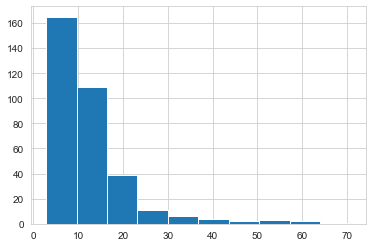

In [48]:
df['Fluctuations'].hist()

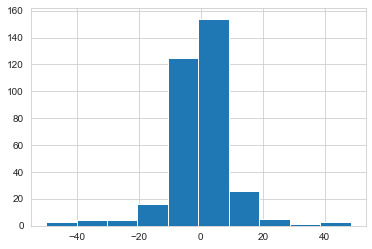

In [53]:
df['Lag1'].hist()

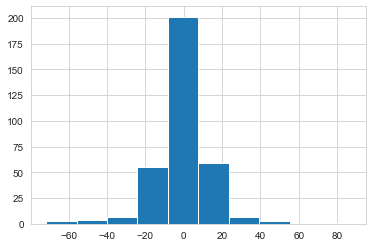

In [49]:
df['Lag2'].hist()

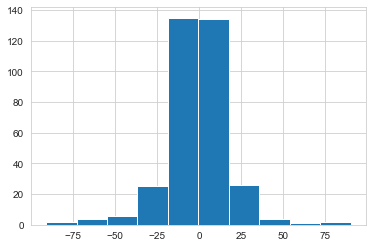

In [50]:
df['Lag3'].hist()

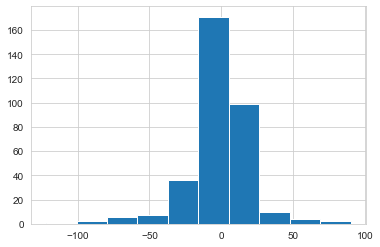

In [51]:
df['Lag4'].hist()

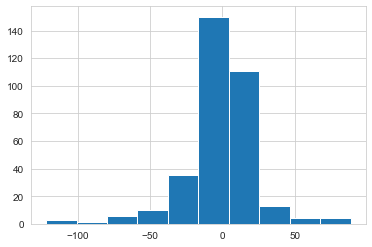

In [52]:
df['Lag5'].hist()

Now we will use Local outlier factor for local anomalies. It measures the local deviation of density of a given sample with respect to its neighbors.
We will use Close, Volume and Fluctuations as the feature for it.


In [31]:
clf = LocalOutlierFactor(n_neighbors=2)
x=pd.DataFrame(df[['Close','Volume','Fluctuations']])
x[["Close", "Volume", "Fluctuations"]] = min_max_scaler.fit_transform(x[["Close", "Volume", "Fluctuations"]])
x=np.array(x)
df['anomaly'] = clf.fit_predict(x)
df1236=pd.DataFrame(df[df['anomaly']==-1])
df.drop('anomaly', axis=1, inplace =True)
df1236.shape

C:\Users\karti\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\karti\anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(35, 19)

We can easily visualize that it is giving local outliers 

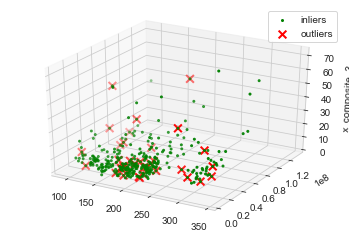

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df['Close'], df['Volume'], zs=df['Fluctuations'], s=4, lw=1, label="inliers",c="green")

ax.scatter(df1236['Close'],df1236['Volume'], df1236['Fluctuations'],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

We can use hidden markov chains as well but it is similar to clustering so will give nearly same results. Now we will analyze all the outliers from all the algorithms

In [49]:
print('Number of anomalies from Bollinger+CCI {}'.format(do1.shape[0]))
print('Number of anomalies from Isolation Forest {}'.format(df1233.shape[0]))
print('Number of anomalies from DBSCAN {}'.format(df1234.shape[0]))
print('Number of anomalies from HBOS {}'.format(dfo2.shape[0]))
print('Number of anomalies from Local outlier factor {}'.format(df1236.shape[0]))
print('Number of anomalies from GESD {}'.format(df47.shape[0]))

print('Number of same anomalies from Bollinger+CCI and Isolation Forest {}'.format(pd.merge(do1, df1233, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and DBSCAN {}'.format(pd.merge(do1, df1234, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and HBOS {}'.format(pd.merge(do1, dfo2, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and Local outlier factor {}'.format(pd.merge(do1, df1236, on='Date').shape[0]))
print('Number of same anomalies from Bollinger+CCI and GESD {}'.format(pd.merge(do1, df47, on='Date').shape[0]))

print('Number of same anomalies from Isolation Forest and DBSCAN {}'.format(pd.merge(df1233, df1234, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and HBOS {}'.format(pd.merge(df1233, dfo2, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and Local outlier factor {}'.format(pd.merge(df1233, df1236, on='Date').shape[0]))
print('Number of same anomalies from Isolation Forest and GESD {}'.format(pd.merge(df1233, df47, on='Date').shape[0]))

print('Number of same anomalies from DBSCAN and HBOS {}'.format(pd.merge(df1234, dfo2, on='Date').shape[0]))
print('Number of same anomalies from DBSCAN and Local outlier factor {}'.format(pd.merge(df1234, df1236, on='Date').shape[0]))
print('Number of same anomalies from DBSCAN and GESD {}'.format(pd.merge(df1234, df47, on='Date').shape[0]))

print('Number of same anomalies from HBOS and Local outlier factor {}'.format(pd.merge(dfo2, df1236, on='Date').shape[0]))
print('Number of same anomalies from HBOS and GESD {}'.format(pd.merge(dfo2, df47, on='Date').shape[0]))

print('Number of same anomalies from Local outlier factor and GESD {}'.format(pd.merge(df1236, df47, on='Date').shape[0])) 

Number of anomalies from Bollinger+CCI 11
Number of anomalies from Isolation Forest 35
Number of anomalies from DBSCAN 18
Number of anomalies from HBOS 35
Number of anomalies from Local outlier factor 35
Number of anomalies from GESD 11
Number of same anomalies from Bollinger+CCI and Isolation Forest 5
Number of same anomalies from Bollinger+CCI and DBSCAN 5
Number of same anomalies from Bollinger+CCI and HBOS 8
Number of same anomalies from Bollinger+CCI and Local outlier factor 2
Number of same anomalies from Bollinger+CCI and GESD 4
Number of same anomalies from Isolation Forest and DBSCAN 18
Number of same anomalies from Isolation Forest and HBOS 22
Number of same anomalies from Isolation Forest and Local outlier factor 8
Number of same anomalies from Isolation Forest and GESD 9
Number of same anomalies from DBSCAN and HBOS 17
Number of same anomalies from DBSCAN and Local outlier factor 4
Number of same anomalies from DBSCAN and GESD 8
Number of same anomalies from HBOS and Local 

All anomalies from DBSCAN are covered in isolation forest

All anomalies from DBSCAN are covered in HBOS 

All anomalies from GESD are covered in HBOS 

Now we will concat anomalies from all the algorithms into single dataframe

In [ ]:
do1.rename(columns={0:'Date'}, inplace=True)
df1233.rename(columns={0:'Date'}, inplace=True)

dconcat1 = pd.concat([do1,df1233,df1234,df1236,df47]).reset_index()
dconcat1 = dconcat1.drop_duplicates(subset='Date')

dconcat1.shape #74 anomalies

In [21]:
dcombined = pd.merge(df, dconcat1, on='Date')
dcombined = pd.DataFrame(dcombined[['Date','Close_x','Volume_x','Fluctuations_x']])

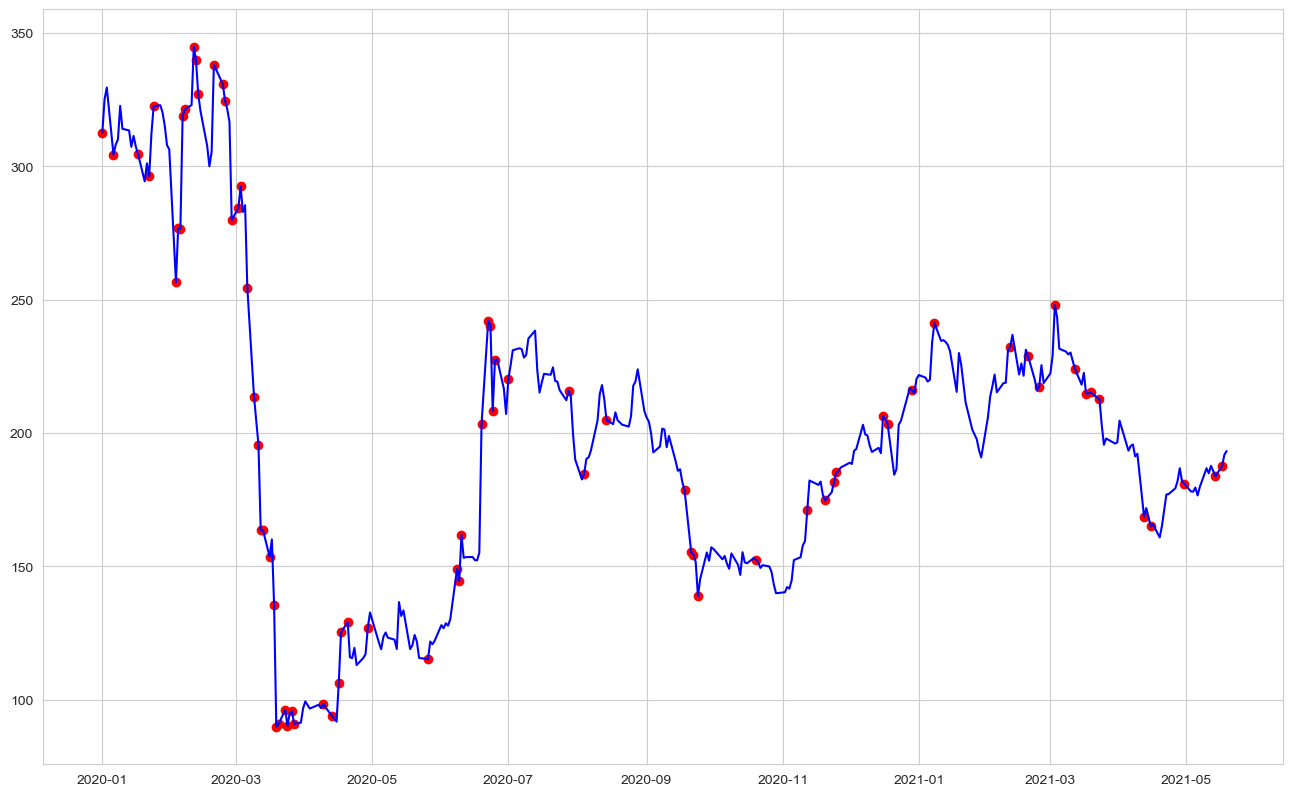

In [193]:
plt.figure(figsize=(16, 10), dpi=100)
plt.plot(df['Close'] , color = 'b')
plt.scatter(x=dcombined['Date'], y=dcombined['Close_x'], color='r')

All anomalies are considered as point anomalies. That is the reason we have approx 20% anomalies from the total dataset. If we classify anomaly on the basis of continuous and point anomaly the count of anomalies will be in a reasonable number. 

In [194]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(dcombined)

         Date     Close_x   Volume_x  Fluctuations_x
0  2020-01-01  312.700012   18294197        7.649994
1  2020-01-06  304.399994   31387511       25.949982
2  2020-01-17  304.649994   11410286        7.850006
3  2020-01-22  296.299988   12620677       10.950012
4  2020-01-24  322.600006   26672842        9.799988
5  2020-02-03  256.600006   32693890       37.800003
6  2020-02-04  276.850006   35923574       25.900024
7  2020-02-05  276.700012   20690497       12.649994
8  2020-02-06  318.950012  103611027       58.199982
9  2020-02-07  321.399994   42832351       17.399994
10 2020-02-11  344.950012   62386677       34.500000
11 2020-02-12  339.750000   59833683       33.100006
12 2020-02-13  327.000000   24055205       18.350006
13 2020-02-20  338.200012   70436641       58.450012
14 2020-02-24  330.850006   40567458       24.799988
15 2020-02-25  324.700012   35753585       25.649994
16 2020-02-28  279.850006   37439449       30.449982
17 2020-03-02  284.399994   70157790       70.

Business Context 

Explanations for anomaly:

2020-02-06: The Monetary Policy                                              Committee(MPC) of Reserve Bank of India(RBI) permitted the extension of project loans for commercial real estate(positive news for the company).This led to the increase of share prices of Indiabulls Housing Finance and as a result of that,The Indiabulls Housing Finance stock ended up as the most traded stock in terms of NSE(See the huge volume) .Big companies like Credit Suisse Singapore Limited,Tower Research Capital Market and others invested in Indiabulls Housing Finance on that day.

2020-02-05 to 2020-02-13:It can be seen that the stock prices kept increasing after this date and after sometime the stock prices kept decreasing.this is because an anouncement of dividend was made on 05-02-2020 and the ex-date was 13-02-2020.
(The prices of the shares normally see a rise when the company is about to announce the dividends. Once the dividends are distributed, the share price plummets immediately.)

2020-03-24 to 2020-03-27: International rating agency Moody's downgraded Indiabulls Housing Finance  on March 24,2020 with a negative outlook, citing challenges in raising funds.This could have been perceived as a negative news for the company and may have led to the  decrease in both trading prices and volumes during this period.

Anomalies from the period 0f 2020-03-24 to 2020-04-09: Other than the Moody's, another prominent Credit Rating Agency ICRA on April 7,2020 downgraded the outlook on the long-term rating of Indiabulls Housing Finance(IBHFL) to negative.All this may have impacted the Indiabulls ousing Finance to trade below a price of 100 during this period.

2020-04-29 :The Delhi High Court on April 29 stayed the interim relief granted to Indiabulls Housing Finance with respect to the repayment of its dues to non-convertible debenture (NCD) holders.The relief was granted in light of the COVID-19 Pandemic which has brought businesses to a halt.This could be perceoived as a positive news for the company which led to trading of significantly high volumes of the stock(much higher volume that the previous 6 and following 6 days) on that day.

2020-06-19: On June 19, Indiabulls Housing Finance was the stock of the day as it witnessed a lot of open market transactions through which  foreign portfolio investors(FPIs) picked up(net) around 2 percent equity stake in the company.As we can make out from the data given that the volume of stocks traded on that day was considerably high .Morgan Stanley Asia(Singapore) bought huge number of shares of the company.

2020-11-12 : There was a board meeting on 11 nov, 2020(12 nov anomaly) after which the quarterly results came out.On that day the company reported a nearly 54 percent decline in its consolidated netprofit to Rs 323.20 crore for the second quarter ended September 30.That may be the reason beacause of which Indiabulls Housing Finance share price surged over 8 percent intraday on November 12 and the model reported it as an anamoly.

But scrapping financial news manually again and again is of no help. Also we cannot get the effect of individual news on stock market so we will scrape the news of target stock then predict the sentiment of each news using our pretrained BERT model.

In [2]:
Base_url = 'https://www.moneycontrol.com/'
List_of_links=[]
all_dates=[]
final_all_dates = []
all_news = []
all_headlines = []
for i in range(2020,2022):
    for j in range(1,10):
        html = requests.get('https://www.moneycontrol.com/stocks/company_info/stock_news.php?sc_id=IHF01&scat=&pageno='+str(j)+'&next=0&durationType=Y&Year='+str(i)+'&duration=1&news_type=')
        soup = BeautifulSoup(html.text,'html.parser')
        sub_links = soup.find_all('a', class_='arial11_summ')
        if not sub_links:
            break;
        dates = soup.find_all('p', class_='PT3 a_10dgry')
        dates = str(dates)
        dates = re.findall('[0-9o/]{2}[\s][A-Z]{1}[a-z]{2}[\s][0-9O/]{4}[\s]', dates)
        dates = [x[:-1] for x in dates]
        all_dates.extend(dates)
        for links in sub_links:
            sp = BeautifulSoup(str(links),'html.parser')  
            tag = sp.a
            category_links = Base_url + tag["href"]
            List_of_links.append(category_links)
            time.sleep(3)
            
for links in List_of_links:
    html = requests.get(links)
    soup = BeautifulSoup(html.text,'html.parser')
    Headlines = soup.find_all('title')
    Headlines = str(Headlines)
    Headlines = Headlines.strip("[<title>")
    Headlines = Headlines.strip("/title>]")
    Headlines = Headlines[ : -1]
    all_headlines.append(Headlines)
    if soup.find('div',{'class':'arti-flow'}):
        news_text = soup.find('div',{'class':'arti-flow'})
    for x in news_text.find_all("script"):
        x.decompose()
    for y in news_text.find_all('style'):
        y.decompose()
    news_text.find_all('a')[-1].decompose()
    news = news_text.text
    news = news[news.find('More'):]
    news = news.split(' ', 2)[2]
    news = news.split(' ', 1)[1]
    news = news.split(' ', 1)[1]
    all_news.append(news)
    
for i in range(len(all_dates)):
    date = all_dates[i].split(" ")
    month = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10',
             'Nov':'11','Dec':'12' }
    date[1] = month[date[1]]
    date.reverse()
    date = '-'.join(date)
    date = datetime.strptime(date, '%Y-%m-%d').date()
    final_all_dates.append(date)
    
dfn = pd.DataFrame()
dfn = pd.DataFrame(list(zip(final_all_dates, all_headlines, all_news)), columns =['Date', 'Headlines', 'News'])

In [5]:
dfn.head()

,Date,Headlines,News
0,2020-11-29,Indiabulls Housing Finance Sells Part Of Its S...,Indiabulls Housing Finance Ltd (IHFL) on Nove...
1,2020-11-11,Indiabulls Housing Finance Net Profit Declines...,Indiabulls Housing Finance on November 11 rep...
2,2020-09-29,Indiabulls Housing Raises Rs 630 Crore By Sell...,I on Tuesday said it has further sold a porti...
3,2020-09-09,Indiabulls Housing Finance Launches QIP With B...,"IndiaBulls Housing Finance, the country’s thi..."
4,2020-08-21,Indiabulls Housing Finance Q1 Net Profit Down ...,Indiabulls Housing Finance on August 21 repor...


In [4]:
dfn.shape

(31, 3)

In [ ]:
dff = dfn.set_index('Date').join(df.set_index('Date'))